# Baseline Model (CF) - K-Nearest Neighbour (KNN)

In [31]:
import pandas as pd
import numpy as np
from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV 
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

## Load Data

In [9]:
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")

In [10]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'address', 'PlaceID',
       'Nama_tempat_wisata', 'Category', 'ReviewerId', 'Rating', 'Reviews'],
      dtype='object')

In [11]:
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
data['rating'] = data['rating'].astype(float)
data.dropna(inplace=True)
data.head()

,Unnamed: 0.1,Unnamed: 0,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
6,6,6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.142390e+20,5.0,amazing pengen kesini lagi
8,8,8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.047430e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


In [12]:
col_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'address', 'Category', 'Reviews']
data = data.drop(columns=col_to_drop)
data.head()

,item_id,Nama_tempat_wisata,user_id,rating
1,0,PASIR PUTIH LUMBAN BULBUL,1.119090e+20,5.0
3,0,PASIR PUTIH LUMBAN BULBUL,1.130720e+20,5.0
4,0,PASIR PUTIH LUMBAN BULBUL,1.061730e+20,5.0
6,0,PASIR PUTIH LUMBAN BULBUL,1.142390e+20,5.0
8,0,PASIR PUTIH LUMBAN BULBUL,1.047430e+20,3.0


In [13]:
data.shape

(22166, 4)

In [14]:
# Define Reader object
reader = Reader(rating_scale=(data['rating'].min(), data['rating'].max()))
dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

## Split Data

In [33]:
# Split data into train (70%), validation (15%), and test (15%)
trainset, testset = train_test_split(dataset, test_size=0.30)

## Create User-Item Matrix

In [34]:
# Create user-item matrix
def create_user_item_matrix(data, user_col='user_id', item_col='item_id', rating_col='rating'):
    data = data.groupby([user_col, item_col])[rating_col].mean().reset_index()
    return data.pivot(index=user_col, columns=item_col, values=rating_col).fillna(0)

# Generate matrices for each split
train_matrix = create_user_item_matrix(train_data)
val_matrix = create_user_item_matrix(val_data).reindex(columns=train_matrix.columns, fill_value=0)
test_matrix = create_user_item_matrix(test_data).reindex(columns=train_matrix.columns, fill_value=0)

# Print the matrices
print("Train Matrix:")
print(train_matrix)
print("\nValidation Matrix:")
print(val_matrix)
print("\nTest Matrix:")
print(test_matrix)

Train Matrix:
item_id       0    1    2    3    4    5    6    8    9    10   ...  92   93   \
user_id                                                         ...             
1.000030e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000040e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000090e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000100e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000120e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1.184390e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.0  0.0   
1.184410e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184430e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  5.0   
1.184440e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184460e+20  

In [35]:
# Filter hanya user dengan minimal 10 interaksi
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts >= 10].index
filtered_data = data[data['user_id'].isin(active_users)]

dataset = Dataset.load_from_df(filtered_data[['user_id', 'Nama_tempat_wisata', 'rating']], reader)

## Tuning KNN Model

In [36]:
param_grid = {
    'k': [3, 5, 7, 10],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True, False]
    }
}

gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(dataset)

# Menampilkan parameter terbaik
print("Best RMSE:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])

Best RMSE: 0.7810104862731407
Best Parameters: {'k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}}


## RMSE & MAE

In [37]:
# Gunakan paameter terbaik
best_params = gs.best_params['rmse']
model = KNNBasic(k=best_params['k'], sim_options=best_params['sim_options'])

# Train the model
trainset = dataset.build_full_trainset()
model.fit(trainset)

# Evaluate on testset
predictions = model.test(testset)

# Hitung metrik evaluasi
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5472
MAE:  0.3865
RMSE: 0.5472, MAE: 0.3865


## Precision@k, Recall@k, and MAP@k 

In [38]:
from collections import defaultdict
import numpy as np

def precision_recall_map_at_k(predictions, k=10, threshold=4.0):
    """
    Menghitung Precision@k, Recall@k, dan MAP@k secara langsung.
    
    Parameters:
    - predictions: Hasil prediksi dari Surprise
    - k: Jumlah top-k item
    - threshold: Ambang batas rating untuk menentukan item relevan
    
    Returns:
    - precision: Nilai Precision@k
    - recall: Nilai Recall@k
    - map_at_k: Nilai MAP@k
    """
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = []
    recalls = []
    average_precisions = []

    for uid, user_ratings in user_est_true.items():
        # Urutkan berdasarkan prediksi rating (descending)
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Ambil top-k item
        top_k = user_ratings[:k]
        
        # Hitung jumlah item relevan di top-k
        relevant_in_top_k = sum((true_r >= threshold) for _, true_r in top_k)
        
        # Hitung total item relevan sebenarnya
        total_relevant = sum((true_r >= threshold) for _, true_r in user_ratings)
        
        # Precision@k
        precision = relevant_in_top_k / k if k > 0 else 0
        precisions.append(precision)
        
        # Recall@k
        recall = relevant_in_top_k / total_relevant if total_relevant > 0 else 0
        recalls.append(recall)
        
        # Average Precision untuk MAP@k
        num_relevant = 0
        precision_at_i = []
        for i, (_, true_r) in enumerate(top_k):
            if true_r >= threshold:  # Item relevan
                num_relevant += 1
                precision_at_i.append(num_relevant / (i + 1))
        
        average_precision = sum(precision_at_i) / num_relevant if num_relevant > 0 else 0
        average_precisions.append(average_precision)
    
    # Rata-rata Precision, Recall, dan MAP
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_map = np.mean(average_precisions)
    
    return mean_precision, mean_recall, mean_map


# Hitung Precision@k, Recall@k, dan MAP@k
precision_at_5, recall_at_5, map_at_5 = precision_recall_map_at_k(predictions, k=5, threshold=4.0)
precision_at_10, recall_at_10, map_at_10 = precision_recall_map_at_k(predictions, k=10, threshold=4.0)

In [39]:
# Tampilkan hasil
print(f"Precision@5: {precision_at_5:.4f}")
print(f"Recall@5: {recall_at_5:.4f}")
print(f"MAP@5: {map_at_5:.4f}")

print(f"Precision@10: {precision_at_10:.4f}")
print(f"Recall@10: {recall_at_10:.4f}")
print(f"MAP@10: {map_at_10:.4f}")

Precision@5: 0.6556
Recall@5: 0.9754
MAP@5: 0.9877
Precision@10: 0.3444
Recall@10: 1.0000
MAP@10: 0.9877


## Visualisasi

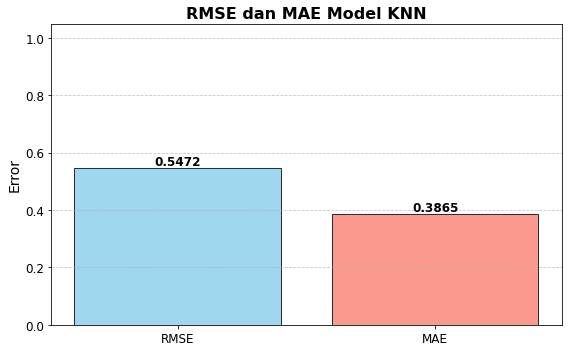

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai RMSE dan MAE yang sudah dihitung
metrics = {'RMSE': rmse, 'MAE': mae}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('RMSE dan MAE Model KNN', fontsize=16, fontweight='bold')
plt.ylabel('Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.5)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

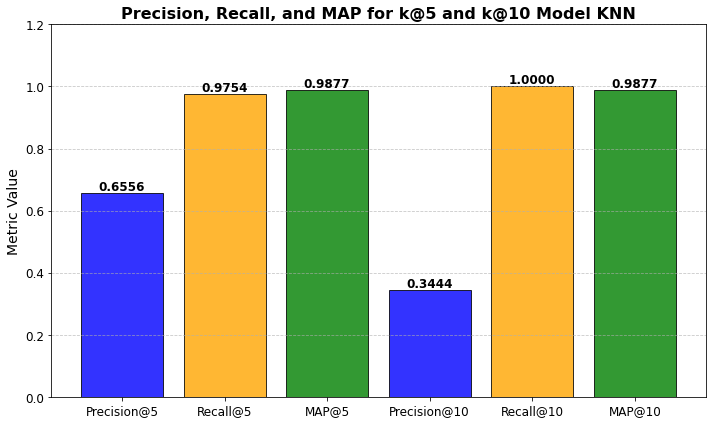

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai Precision, Recall, dan MAP untuk k@5 dan k@10
metrics = {
    'Precision@5': 0.6556,
    'Recall@5': 0.9754,
    'MAP@5': 0.9877,
    'Precision@10': 0.3444,
    'Recall@10': 1.0000,
    'MAP@10': 0.9877
}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'blue', 'orange', 'green'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('Precision, Recall, and MAP for k@5 and k@10 Model KNN', fontsize=16, fontweight='bold')
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.2)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [60]:
def get_top_n_recommendations_table(predictions, user_id, n=5):
    """
    Mengembalikan top-N rekomendasi dalam bentuk tabel.
    
    Parameters:
    - predictions: List prediksi dari Surprise
    - user_id: ID user yang ingin ditampilkan rekomendasinya
    - n: Jumlah rekomendasi yang diinginkan (default: 5)
    
    Returns:
    - DataFrame berisi item_id, nama tempat wisata, dan prediksi rating
    """
    # Filter prediksi untuk user tertentu
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    
    # Urutkan berdasarkan rating prediksi (descending)
    user_predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Ambil top-N rekomendasi
    top_n = user_predictions[:n]
    
    # Format data untuk DataFrame
    top_n_data = []
    for pred in top_n:
        place_name = data[data['item_id'] == pred.iid]['Nama_tempat_wisata'].iloc[0]
        top_n_data.append({'Place ID': pred.iid, 'Nama Tempat Wisata': place_name, 'Predicted Rating': pred.est})
    
    # Konversi ke DataFrame
    return pd.DataFrame(top_n_data)

# Pilih user_id untuk melihat rekomendasi
user_id = '1.08733e+20'

# Dapatkan daftar semua item di dataset
all_items = set(data['item_id'].unique())

# Cari item yang belum di-rating oleh user
rated_items = set(data[data['user_id'] == user_id]['item_id'])
unrated_items = all_items - rated_items

# Buat testset untuk user dengan semua item yang belum di-rating
user_testset = [(user_id, item_id, 0) for item_id in unrated_items]

# Prediksi untuk semua item di testset
user_predictions = model.test(user_testset)

# Dapatkan top 5 rekomendasi dalam bentuk tabel
top_5_recommendations_table = get_top_n_recommendations_table(user_predictions, user_id, n=5)

# Tampilkan tabel
print("Top 5 rekomendasi untuk User {}: dengan Model KNN".format(user_id))
print(top_5_recommendations_table)

Top 5 rekomendasi untuk User 1.08733e+20: dengan Model KNN
   Place ID                               Nama Tempat Wisata  Predicted Rating
0         0                        PASIR PUTIH LUMBAN BULBUL          4.505797
1         1  Patung Yesus, Bukit Sibea-bea, Huta Harian Boho          4.505797
2         2                      Pelabuhan wisata danau toba          4.505797
3         3                                        Singgolom          4.505797
4         4                        Puncak Panorama Aek Nauli          4.505797
